In [418]:
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import re

#df = pd.read_csv('all_results_combined.csv')
df = pd.read_csv('Combined_Results_All.csv')
df['Age'] = 2021 - df['Year of Birth']

#Filter to leave only rows with a valid test score and parts completed > 0
df = df.dropna(how='any', subset=['Parts Completed','Overall Score'])
df = df[df['Parts Completed'] != 0]

#Filter to leave only pre-test survey info
df = df[['Overall Score','Location','Years of Experience','Current Industry','Gender','Age']]
df

,Overall Score,Location,Years of Experience,Current Industry,Gender,Age
0,2.9,NaN,NaN,NaN,NaN,NaN
2,5.0,Australia,3.0,Government Administration,Male,49.0
6,2.5,Pakistan,6.0,Cosmetics,Male,29.0
7,3.4,Pakistan,2.0,Information Technology and Services,Male,31.0
9,1.1,United States,8.0,Marketing and Advertising,Male,35.0
...,...,...,...,...,...,...
2011,3.3,Netherlands,5.0,Accounting,Female,27.0
2015,5.8,Israel,17.0,Electrical/Electronic Manufacturing,Male,44.0
2017,4.3,Turkey,5.0,Banking,Male,32.0
2019,0.4,Saudi Arabia,3.0,Investment Management,Female,24.0


# 1. Regression on subset of data where no NaN values are present

In [419]:
df1 = df.dropna(how='any').copy()
df1

,Overall Score,Location,Years of Experience,Current Industry,Gender,Age
2,5.0,Australia,3.0,Government Administration,Male,49.0
6,2.5,Pakistan,6.0,Cosmetics,Male,29.0
7,3.4,Pakistan,2.0,Information Technology and Services,Male,31.0
9,1.1,United States,8.0,Marketing and Advertising,Male,35.0
10,4.4,Australia,3.0,Information Technology and Services,Male,36.0
...,...,...,...,...,...,...
2011,3.3,Netherlands,5.0,Accounting,Female,27.0
2015,5.8,Israel,17.0,Electrical/Electronic Manufacturing,Male,44.0
2017,4.3,Turkey,5.0,Banking,Male,32.0
2019,0.4,Saudi Arabia,3.0,Investment Management,Female,24.0


### Converting Location to variables
Top ten most common countries will have their own feature, so the 0-value will be observations whose location is outside the top ten.

In [420]:
# Get top ten most common locations for OneHotEncoding. All countries outside top ten will have OneHotEncoded Variables set to 0.
common_loc_dict = dict(df1['Location'].value_counts()[:10])
common_loc_list = list(common_loc_dict.keys())

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories=[common_loc_list], handle_unknown='ignore')
transformed = enc.fit_transform(df1[['Location']]).toarray()

print(enc.categories_[0])
print(transformed)

for i, country in enumerate(enc.categories_[0]):
    df1['Country_'+country] = transformed[:,i]

df1 = df1.drop(columns='Location')

['Canada' 'Australia' 'United Arab Emirates' 'India' 'Germany' 'Portugal'
 'United Kingdom' 'Pakistan' 'New Zealand' 'Brazil']
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Converting Gender to variables
Male and Female will have their own feature variables, so when both of these is 0, it will be equivalent to 'Other'

In [421]:
enc = OneHotEncoder(categories=[['Female','Other']], handle_unknown='ignore')
transformed = enc.fit_transform(df1[['Gender']]).toarray()

print(enc.categories_[0])
print(transformed)

for i, gender in enumerate(enc.categories_[0]):
    df1['Gender_'+gender] = transformed[:,i]

df1 = df1.drop(columns='Gender')

['Female' 'Other']
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [1. 0.]
 [0. 0.]]


### Converting Current Industry to variables
Top ten most common Current Industries will have their own feature, so the 0-value will be observations whose industry is outside the top ten.

In [422]:
common_ind_dict = dict(df1['Current Industry'].value_counts()[:10])
common_ind_list = list(common_ind_dict.keys())

enc = OneHotEncoder(categories=[common_ind_list], handle_unknown='ignore')
transformed = enc.fit_transform(df1[['Current Industry']]).toarray()

print(enc.categories_[0])
print(transformed)

for i, industry in enumerate(enc.categories_[0]):
    df1['Current_Industry_'+industry] = transformed[:,i]

df1 = df1.drop(columns='Current Industry')

['Information Technology and Services' 'Banking' 'Oil & Energy'
 'Computer Software' 'Financial Services' 'Management Consulting' 'Retail'
 'Telecommunications' 'Accounting' 'Airlines/Aviation']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


# Regression

### Model 1
Contains all the features

In [438]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

X_train = df1.drop(columns=['Overall Score', 'Age', 'Years of Experience'])
X_train = sm.add_constant(X_train)
y_train = df1['Overall Score']

# Note the difference in argument order
model1 = sm.OLS(y_train, X_train).fit()
predictions = model1.predict(X_train) # make the predictions by the model

# Print out the statistics
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall Score   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     4.095
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           1.84e-09
Time:                        20:02:24   Log-Likelihood:                -1315.5
No. Observations:                 678   AIC:                             2677.
Df Residuals:                     655   BIC:                             2781.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    3.5369      0.157     22.515      0.000       3.228       3.845
Country_Canada                                           0.2346      0.232      1.012      0.312      -0.221       0.690
Country_Australia                                        0.2267      0.215      1.056      0.291      -0.195       0.648
Country_United Arab Emirates                            -1.2205      0.225     -5.417      0.000      -1.663      -0.778
Country_India                                           -0.4537      0.242     -1.875      0.061      -0.929       0.021
Country_Germany                                         -0.5453      0.291     -1.876      0.061      -1.116       0.025
Country_Portugal                                        -0.5799      0.451     -1.285      0.199      -1.466       0.307
Country_United Kingdom                                  -0.3220      0.469     -0.686      0.493      -1.243       0.599
Country_Pakistan                                        -0.5208      0.495     -1.052      0.293      -1.493       0.451
Country_New Zealand                                     -0.2372      0.496     -0.479      0.632      -1.210       0.736
Country_Brazil                                          -0.5796      0.513     -1.129      0.259      -1.588       0.429
Gender_Female                                           -0.5592      0.157     -3.567      0.000      -0.867      -0.251
Gender_Other                                            -0.7798      1.230     -0.634      0.526      -3.195       1.636
Current_Industry_Information Technology and Services     0.2181      0.192      1.137      0.256      -0.158       0.595
Current_Industry_Banking                                 0.0529      0.251      0.210      0.833      -0.441       0.546
Current_Industry_Oil & Energy                            0.0706      0.299      0.236      0.813      -0.516       0.658
Current_Industry_Computer Software                      -0.1245      0.267     -0.467      0.641      -0.648       0.399
Current_Industry_Financial Services                      0.1150      0.296      0.388      0.698      -0.466       0.696
Current_Industry_Management Consulting                   0.8590      0.373      2.303      0.022       0.127       1.591
Current_Industry_Retail                                 -0.5062      0.388     -1.303      0.193      -1.269       0.256
Current_Industry_Telecommunications                      0.0477      0.401      0.119      0.905      -0.739       0.835
Current_Industry_Accounting                             -0.6845      0.461     -1.485      0.138      -1.590       0.221
Current_Industry_Airlines/Aviation                       0

### Model 2
Removes Current Industry

In [439]:
r = re.compile("Current_Industry_.*")
curr_Ind = list(filter(r.match, list(df1.columns)))
df2 = df1.drop(columns=curr_Ind)
df2 = sm.add_constant(df2)

X_train = df2.drop(columns=['Overall Score', 'Age', 'Years of Experience'])
y_train = df2['Overall Score']

# Note the difference in argument order
model2 = sm.OLS(y_train, X_train).fit()
predictions = model2.predict(X_train) # make the predictions by the model

# Print out the statistics
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall Score   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     6.430
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           6.92e-11
Time:                        20:04:59   Log-Likelihood:                -1322.0
No. Observations:                 678   AIC:                             2670.
Df Residuals:                     665   BIC:                             2729.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            3.5961      0.135     26.556      0.000       3.330       3.862
Country_Canada                   0.2833      0.206      1.378      0.169      -0.120       0.687
Country_Australia                0.2243      0.213      1.055      0.292      -0.193       0.642
Country_United Arab Emirates    -1.2730      0.220     -5.777      0.000      -1.706      -0.840
Country_India                   -0.4079      0.238     -1.714      0.087      -0.875       0.059
Country_Germany                 -0.5588      0.290     -1.929      0.054      -1.128       0.010
Country_Portugal                -0.7077      0.448     -1.579      0.115      -1.588       0.173
Country_United Kingdom          -0.2685      0.462     -0.581      0.561      -1.176       0.639
Country_Pakistan                -0.5511      0.494     -1.115      0.265      -1.521       0.419
Country_New Zealand             -0.2445      0.494     -0.495      0.621      -1.214       0.725
Country_Brazil                  -0.5426      0.512     -1.059      0.290      -1.548       0.463
Gender_Female                   -0.5857      0.155     -3.780      0.000      -0.890      -0.281
Gender_Other                    -0.4083      1.220     -0.335      0.738      -2.803       1.987
==============================================================================
Omnibus:                        3.546   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                3.547
Skew:                           0.149   Prob(JB):                        0.170
Kurtosis:                       2.807   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Compare if Model 1 with all predictors with all features is better than Model 2 without Current Industry

In [440]:
anovaResults = anova_lm(model2, model1)
print(anovaResults)

   df_resid          ssr  df_diff    ss_diff        F    Pr(>F)
0     665.0  1960.497574      0.0        NaN      NaN       NaN
1     655.0  1923.416451     10.0  37.081123  1.26276  0.247896


### Model 3
Removes Country from the full model

In [441]:
r = re.compile("Country_.*")
country_cols = list(filter(r.match, list(df1.columns)))
df3 = df1.drop(columns=country_cols)
df3 = sm.add_constant(df3)

X_train = df3.drop(columns=['Overall Score', 'Age', 'Years of Experience'])
y_train = df3['Overall Score']

# Note the difference in argument order
model3 = sm.OLS(y_train, X_train).fit()
predictions = model3.predict(X_train) # make the predictions by the model

# Print out the statistics
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall Score   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.269
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           0.000132
Time:                        20:05:30   Log-Likelihood:                -1339.8
No. Observations:                 678   AIC:                             2706.
Df Residuals:                     665   BIC:                             2764.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    3.2596      0.117     27.912      0.000       3.030       3.489
Gender_Female                                           -0.5837      0.158     -3.687      0.000      -0.895      -0.273
Gender_Other                                            -0.4586      1.260     -0.364      0.716      -2.934       2.016
Current_Industry_Information Technology and Services     0.4054      0.192      2.108      0.035       0.028       0.783
Current_Industry_Banking                                -0.0931      0.256     -0.363      0.717      -0.597       0.410
Current_Industry_Oil & Energy                            0.4482      0.269      1.667      0.096      -0.080       0.976
Current_Industry_Computer Software                       0.0902      0.270      0.333      0.739      -0.441       0.621
Current_Industry_Financial Services                      0.1337      0.303      0.441      0.659      -0.461       0.729
Current_Industry_Management Consulting                   0.9981      0.373      2.673      0.008       0.265       1.731
Current_Industry_Retail                                 -0.6064      0.392     -1.546      0.122      -1.376       0.164
Current_Industry_Telecommunications                      0.1272      0.409      0.311      0.756      -0.677       0.931
Current_Industry_Accounting                             -0.9138      0.470     -1.946      0.052      -1.836       0.008
Current_Industry_Airlines/Aviation                       0.0354      0.501      0.071      0.944      -0.949       1.020
==============================================================================
Omnibus:                        6.086   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                5.739
Skew:                           0.180   Prob(JB):                       0.0567
Kurtosis:                       2.729   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Compare if Model 1 with all predictors with all features is better than Model 3 without Country

In [442]:
anovaResults = anova_lm(model3, model1)
print(anovaResults)

   df_resid          ssr  df_diff     ss_diff        F        Pr(>F)
0     665.0  2066.109276      0.0         NaN      NaN           NaN
1     655.0  1923.416451     10.0  142.692825  4.85926  8.835320e-07


### Model 4
Contains non-categorical variables only.

In [428]:
df4 = df1[['Overall Score', 'Years of Experience', 'Age', 'Gender_Female', 'Gender_Other']]
df4 = sm.add_constant(df4)

X_train = df4.drop(columns='Overall Score')
y_train = df4['Overall Score']

# Note the difference in argument order
model4 = sm.OLS(y_train, X_train).fit()
predictions = model4.predict(X_train) # make the predictions by the model

# Print out the statistics
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall Score   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     5.379
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           0.000288
Time:                        19:12:09   Log-Likelihood:                -1348.5
No. Observations:                 678   AIC:                             2707.
Df Residuals:                     673   BIC:                             2730.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.2557      0.370      8.789      0.000       2.528       3.983
Years of Experience    -0.0402      0.020     -1.996      0.046      -0.080      -0.001
Age                     0.0131      0.014      0.951      0.342      -0.014       0.040
Gender_Female          -0.6612      0.157     -4.209      0.000      -0.970      -0.353
Gender_Other            0.0595      1.264      0.047      0.962      -2.423       2.542
==============================================================================
Omnibus:                        7.023   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                5.938
Skew:                           0.152   Prob(JB):                       0.0513
Kurtosis:                       2.657   Cond. No.                         645.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [429]:
anovaResults = anova_lm(model4, model3)
print(anovaResults)

   df_resid          ssr  df_diff    ss_diff         F   Pr(>F)
0     673.0  2120.189945      0.0        NaN       NaN      NaN
1     663.0  2051.715443     10.0  68.474501  2.212714  0.01564


In [433]:
df5 = df1[['Overall Score', 'Gender_Female', 'Gender_Other']]
df5 = sm.add_constant(df5)

X_train = df5.drop(columns='Overall Score')
y_train = df5['Overall Score']

# Note the difference in argument order
model5 = sm.OLS(y_train, X_train).fit()
predictions = model5.predict(X_train) # make the predictions by the model

# Print out the statistics
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall Score   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     8.424
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           0.000243
Time:                        19:31:57   Log-Likelihood:                -1350.8
No. Observations:                 678   AIC:                             2708.
Df Residuals:                     675   BIC:                             2721.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.3918      0.079     42.776      0.000       3.236       3.548
Gender_Female    -0.6433      0.157     -4.104      0.000      -0.951      -0.336
Gender_Other     -0.0918      1.260     -0.073      0.942      -2.566       2.382
==============================================================================
Omnibus:                        6.982   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                6.137
Skew:                           0.168   Prob(JB):                       0.0465
Kurtosis:                       2.676   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [436]:
anovaResults = anova_lm(model5, model6)
print(anovaResults)

   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0     675.0  2134.688719      0.0        NaN       NaN       NaN
1     674.0  2123.038980      1.0  11.649739  3.698436  0.054884


In [435]:
df6 = df1[['Overall Score', 'Years of Experience', 'Gender_Female', 'Gender_Other']]
df6 = sm.add_constant(df6)

X_train = df6.drop(columns='Overall Score')
y_train = df6['Overall Score']

# Note the difference in argument order
model6 = sm.OLS(y_train, X_train).fit()
predictions = model6.predict(X_train) # make the predictions by the model

# Print out the statistics
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Overall Score   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     6.871
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           0.000146
Time:                        19:31:59   Log-Likelihood:                -1349.0
No. Observations:                 678   AIC:                             2706.
Df Residuals:                     674   BIC:                             2724.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.5861      0.128     27.947      0.000       3.334       3.838
Years of Experience    -0.0260      0.014     -1.923      0.055      -0.053       0.001
Gender_Female          -0.6677      0.157     -4.255      0.000      -0.976      -0.360
Gender_Other           -0.0651      1.258     -0.052      0.959      -2.534       2.404
==============================================================================
Omnibus:                        6.907   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                5.973
Skew:                           0.159   Prob(JB):                       0.0505
Kurtosis:                       2.669   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [291]:
df4.to_csv('test_df4.csv')

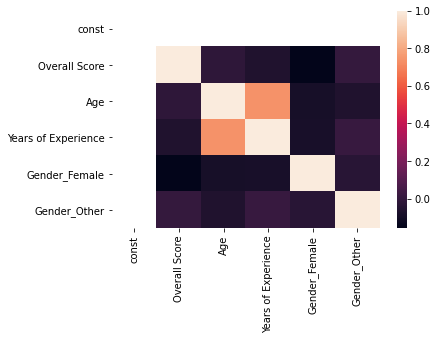

In [407]:
import seaborn as sns
sns.heatmap(df6.corr());

In [381]:
df6.drop(columns='const').corr()

,Overall Score,Age,Gender_Male,Gender_Other
Overall Score,1.000000,-0.015868,0.155168,0.002197
Age,-0.015868,1.000000,0.094117,-0.058643
Gender_Male,0.155168,0.094117,1.000000,-0.092216
Gender_Other,0.002197,-0.058643,-0.092216,1.000000


In [345]:
len(df['Current Industry'].unique())

82

In [448]:

#df = pd.read_csv('all_results_combined.csv')
df = pd.read_csv('Combined_Results_All.csv')
df['Age'] = 2021 - df['Year of Birth']

#Filter to leave only rows with a valid test score and parts completed > 0
df = df.dropna(how='any', subset=['Parts Completed','Overall Score'])
df = df[df['Parts Completed'] != 0]

#Filter to leave only pre-test survey info
df = df[['Overall Score','Location','Years of Experience','Current Industry','Gender','Age', 'Availability']]
df

,Overall Score,Location,Years of Experience,Current Industry,Gender,Age,Availability
0,2.9,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,Australia,3.0,Government Administration,Male,49.0,NaN
6,2.5,Pakistan,6.0,Cosmetics,Male,29.0,NaN
7,3.4,Pakistan,2.0,Information Technology and Services,Male,31.0,NaN
9,1.1,United States,8.0,Marketing and Advertising,Male,35.0,NaN
...,...,...,...,...,...,...,...
2011,3.3,Netherlands,5.0,Accounting,Female,27.0,NaN
2015,5.8,Israel,17.0,Electrical/Electronic Manufacturing,Male,44.0,NaN
2017,4.3,Turkey,5.0,Banking,Male,32.0,NaN
2019,0.4,Saudi Arabia,3.0,Investment Management,Female,24.0,NaN


In [152]:
df_nan_any = df[df.isna().any(axis=1)]
df_nan_any

,Overall Score,Location,Years of Experience,Current Industry,Gender,Age
0,2.9,NaN,NaN,NaN,NaN,NaN
20,0.3,Pakistan,2.0,Information Technology and Services,Male,NaN
86,0.3,Australia,5.0,Computer Software,Male,NaN
92,4.1,Australia,5.0,Information Technology and Services,Male,NaN
111,4.8,NaN,NaN,NaN,NaN,NaN
119,4.0,Australia,2.0,Banking,Male,NaN
155,5.1,Australia,1.0,Information Technology and Services,Female,NaN
162,0.9,Algeria,3.0,Education Management,NaN,NaN
214,4.7,NaN,NaN,NaN,NaN,NaN
235,7.8,Australia,11.0,Government Administration,NaN,NaN


In [153]:
df_nan_any.isna().sum()

Overall Score            0
Location                41
Years of Experience     23
Current Industry       204
Gender                  61
Age                    130
dtype: int64

In [154]:
df_nan_any.isna().sum(axis=1).value_counts()

1    193
2     34
5     23
4     14
3      9
dtype: int64

In [155]:
df_nan_any[df[df.isna().any(axis=1)].isna().sum(axis=1) == 1]

,Overall Score,Location,Years of Experience,Current Industry,Gender,Age
20,0.3,Pakistan,2.0,Information Technology and Services,Male,NaN
86,0.3,Australia,5.0,Computer Software,Male,NaN
92,4.1,Australia,5.0,Information Technology and Services,Male,NaN
119,4.0,Australia,2.0,Banking,Male,NaN
155,5.1,Australia,1.0,Information Technology and Services,Female,NaN
255,3.8,Australia,7.0,Financial Services,Male,NaN
310,4.3,India,10.0,Financial Services,Male,NaN
347,5.0,Australia,1.0,Information Technology and Services,Other,NaN
504,0.6,Australia,10.0,Computer Software,Male,NaN
582,1.7,New Zealand,10.0,Government Administration,Male,NaN


In [258]:
dict(df['Current Industry'].value_counts()[:40])

{'Information Technology and Services': 140,
 'Oil & Energy': 65,
 'Banking': 64,
 'Computer Software': 57,
 'Financial Services': 42,
 'Management Consulting': 25,
 'Retail': 22,
 'Telecommunications': 21,
 'Accounting': 15,
 'Airlines/Aviation': 14,
 'Hospital & Health Care': 13,
 'Automotive': 13,
 'Construction': 13,
 'Education Management': 13,
 'Government Administration': 13,
 'Consumer Goods': 13,
 'Higher Education': 11,
 'Logistics and Supply Chain': 10,
 'Pharmaceuticals': 10,
 'Hospitality': 9,
 'Internet': 8,
 'Gambling & Casinos': 7,
 'Transportation/Trucking/Railroad': 7,
 'Consumer Services': 7,
 'Food & Beverages': 7,
 'Marketing and Advertising': 7,
 'Insurance': 7,
 'Electrical/Electronic Manufacturing': 7,
 'Utilities': 6,
 'Research': 6,
 'Information Services': 5,
 'Mechanical or Industrial Engineering': 5,
 'Real Estate': 4,
 'Leisure, Travel & Tourism': 4,
 'Mining & Metals': 4,
 'Commercial Real Estate': 4,
 'Environmental Services': 4,
 'Civil Engineering': 4,

In [99]:
df.dropna(how='any')

,Candidate Test Id,Parts Completed,Overall Score,Location,Years of Experience,Current Industry,Gender,Age
2,25226,3.0,5.0,Australia,3.0,Government Administration,Male,49.0
6,26316,3.0,2.5,Pakistan,6.0,Cosmetics,Male,29.0
7,25199,3.0,3.4,Pakistan,2.0,Information Technology and Services,Male,31.0
9,25917,3.0,1.1,United States,8.0,Marketing and Advertising,Male,35.0
10,25934,3.0,4.4,Australia,3.0,Information Technology and Services,Male,36.0
...,...,...,...,...,...,...,...,...
2011,27604,3.0,3.3,Netherlands,5.0,Accounting,Female,27.0
2015,27191,3.0,5.8,Israel,17.0,Electrical/Electronic Manufacturing,Male,44.0
2017,27614,3.0,4.3,Turkey,5.0,Banking,Male,32.0
2019,27316,3.0,0.4,Saudi Arabia,3.0,Investment Management,Female,24.0


In [120]:
df[300:320]

,Candidate Test Id,Parts Completed,Overall Score,Location,Years of Experience,Current Industry,Gender,Age
710,24722,1.0,4.2,Argentina,4.0,Airlines/Aviation,Female,34.0
716,26858,1.0,4.2,Germany,5.0,Telecommunications,Male,28.0
718,24033,1.0,3.8,Germany,4.0,Pharmaceuticals,Male,28.0
720,24027,1.0,2.3,Russia,7.0,Information Technology and Services,Male,39.0
721,23999,1.0,4.2,Russia,10.0,Information Technology and Services,Male,38.0
722,26851,1.0,3.3,Poland,1.0,Financial Services,Male,28.0
723,25306,1.0,1.0,India,0.0,NaN,Male,24.0
725,27523,1.0,0.0,United Kingdom,4.0,Financial Services,Female,28.0
727,24022,1.0,4.7,NaN,3.0,NaN,NaN,NaN
728,25086,1.0,4.1,Hungary,0.0,Higher Education,Female,24.0


In [87]:
#df[df['Candidate Test Id'].duplicated(keep='first') == False]

,Candidate Test Id,Parts Completed,Overall Score,Location,Years of Experience,Current Industry,Gender,Age,Availability
0,23045,3.0,2.9,NaN,NaN,NaN,NaN,NaN,NaN
2,25226,3.0,5.0,Australia,3.0,Government Administration,Male,49.0,NaN
6,26316,3.0,2.5,Pakistan,6.0,Cosmetics,Male,29.0,NaN
7,25199,3.0,3.4,Pakistan,2.0,Information Technology and Services,Male,31.0,NaN
9,25917,3.0,1.1,United States,8.0,Marketing and Advertising,Male,35.0,NaN
...,...,...,...,...,...,...,...,...,...
2011,27604,3.0,3.3,Netherlands,5.0,Accounting,Female,27.0,NaN
2015,27191,3.0,5.8,Israel,17.0,Electrical/Electronic Manufacturing,Male,44.0,NaN
2017,27614,3.0,4.3,Turkey,5.0,Banking,Male,32.0,NaN
2019,27316,3.0,0.4,Saudi Arabia,3.0,Investment Management,Female,24.0,NaN


In [90]:
df = pd.read_csv('all_results_combined.csv')
df[df['Candidate Test Id'].duplicated(keep=False)].sort_values(by='Candidate Test Id')

,Unnamed: 0,Candidate Test Id,Date Invited,Date Started,Date Completed,Parts Completed,Overall Score,Chart Interpretation score,Chart Interpretation Self Rating,Data Literacy score,...,Data Analysis Self Rating,Business Acumen score,Business Acumen Self Rating,test_id,Location,Years of Experience,Current Industry,Gender,Year of Birth,Availability
102,853,14128,12/02/2021 11:21,13/02/2021 6:57,13/02/2021 10:56,2,5.9,NaN,NaN,NaN,...,NaN,NaN,NaN,619.0,Canada,20.0,Oil & Energy,Male,NaN,NaN
194,852,14128,2/03/2021 5:39,4/03/2021 8:15,4/03/2021 9:49,2,5.2,NaN,NaN,NaN,...,NaN,NaN,NaN,619.0,Canada,20.0,Oil & Energy,Male,NaN,NaN
845,790,14146,12/02/2021 11:21,15/02/2021 5:52,15/02/2021 7:02,2,1.1,NaN,NaN,NaN,...,NaN,NaN,NaN,619.0,Canada,15.0,Oil & Energy,Female,1962.0,NaN
716,789,14146,24/06/2021 5:28,25/06/2021 8:37,25/06/2021 9:43,2,2.2,NaN,NaN,NaN,...,NaN,NaN,NaN,619.0,Canada,15.0,Oil & Energy,Female,1962.0,NaN
955,791,14254,7/01/2021 7:37,26/02/2021 7:23,26/02/2021 11:31,2,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
956,792,14254,19/02/2021 15:30,NaN,NaN,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655,774,14482,2/03/2021 5:39,8/03/2021 7:42,8/03/2021 8:46,2,2.6,NaN,NaN,NaN,...,NaN,NaN,NaN,609.0,Canada,12.0,Information Technology and Services,Male,1976.0,NaN
254,775,14482,23/03/2021 2:35,26/03/2021 0:56,26/03/2021 2:08,2,4.8,NaN,NaN,NaN,...,NaN,NaN,NaN,609.0,Canada,12.0,Information Technology and Services,Male,1976.0,NaN
581,795,14496,2/03/2021 5:39,4/03/2021 7:59,4/03/2021 9:08,2,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,609.0,Canada,13.0,Oil & Energy,Male,1982.0,NaN
653,796,14496,23/03/2021 2:35,25/03/2021 7:15,25/03/2021 14:35,2,2.6,NaN,NaN,NaN,...,NaN,NaN,NaN,609.0,Canada,13.0,Oil & Energy,Male,1982.0,NaN


In [27]:
sns.displot(x=df[ <= timedelta(hours = 24)]['Self Awareness'])

,Candidate Test Id,Overall Score,test_id,Location,Years of Experience,Current Industry,Gender,Year of Birth,Availability
0,27613,8.4,1165.0,India,3.0,Management Consulting,Male,1993.0,NaN
1,25015,8.3,983.0,Brazil,3.0,Furniture,Male,1995.0,NaN
2,22412,8.2,983.0,Australia,4.0,Banking,Male,1990.0,NaN
3,24325,8.2,951.0,Australia,7.0,NaN,Male,1991.0,1 months notice
4,19710,8.2,951.0,Australia,4.0,NaN,Male,1994.0,1 months notice
...,...,...,...,...,...,...,...,...,...
960,24135,0.0,609.0,Canada,10.0,Mining & Metals,Male,1991.0,NaN
961,14761,0.0,609.0,Canada,15.0,Computer Software,NaN,NaN,NaN
962,14555,0.0,609.0,Canada,10.0,Oil & Energy,Male,1982.0,NaN
963,14484,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
from datetime import datetime, timedelta
timedelta(hours = 24)
df.dtypes#df['Date Completed'] - df['Date Started']

Unnamed: 0                                int64
Unnamed: 0.1                              int64
Candidate Test Id                         int64
Date Invited                             object
Date Started                             object
Date Completed                           object
Parts Completed                         float64
Overall Score                           float64
Chart Interpretation score              float64
Chart Interpretation Self Rating        float64
Data Literacy score                     float64
Data Literacy Self Rating               float64
Data Management score                   float64
Data Management Self Rating             float64
Relational Databases score              float64
Relational Databases Self Rating        float64
Reports & Visualisations score          float64
Reports & Visualisations Self Rating    float64
SQL score                               float64
SQL Self Rating                         float64
Statistics score                        

In [78]:
df['Parts Completed'].value_counts()

3.0    678
1.0    117
2.0    115
0.0     15
Name: Parts Completed, dtype: int64

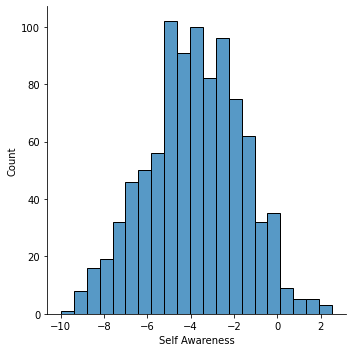

In [65]:
sns.displot(x=df['Self Awareness'])

In [59]:
2021 - df[['Year of Birth']]

,Year of Birth
0,NaN
1,49.0
2,29.0
3,31.0
4,35.0
...,...
920,27.0
921,44.0
922,32.0
923,24.0


In [133]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)